# Lazy Operations

In this section, you will lazy-load data, visualise the task graph while loading data, and use `.compute()` to calculate the a new NDVI band using red and nir bands.

## Load Packages

In [1]:
import datacube 
import matplotlib.pyplot as plt
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.plotting import rgb, display_map

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Connecting to the datacube 

In [2]:
dc = datacube.Datacube(app='Step2')

## Lazy-loading data

In [3]:
lazy_data = dc.load(product='gm_s2_annual',
                   measurements=['blue','green','red','nir'],
                   x=(31.90, 32.00),
                   y=(30.49, 30.40),
                   time=('2021-01-01', '2021-12-31'),
                   dask_chunks={'time':1,'x':500, 'y':500})

lazy_data

<xarray.Dataset>
Dimensions:      (time: 1, y: 994, x: 965)
Coordinates:
  * time         (time) datetime64[ns] 2021-07-02T11:59:59.999999
  * y            (y) float64 3.713e+06 3.713e+06 ... 3.703e+06 3.703e+06
  * x            (x) float64 3.078e+06 3.078e+06 ... 3.088e+06 3.088e+06
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

## Viewing the task graph

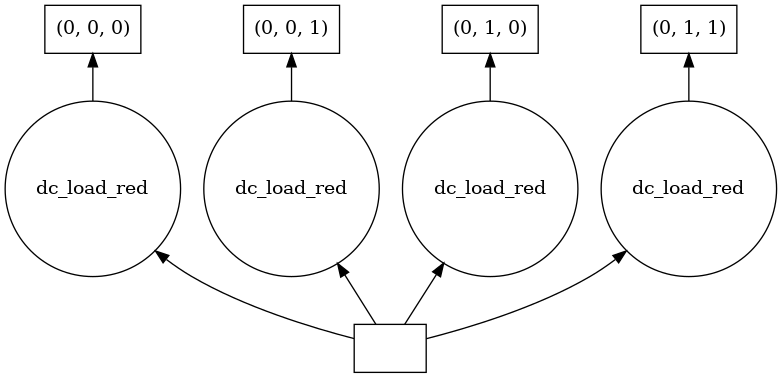

In [4]:
lazy_data.red.data.visualize()

By requesting a small portion of the red band, we can use .visualize() to show us where in the dataset the data comes from.

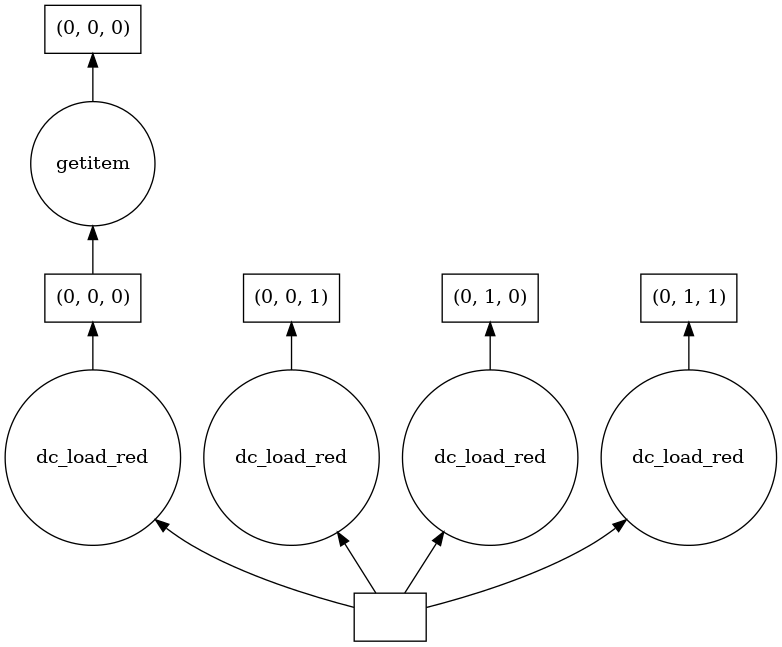

In [5]:
extract_from_red = lazy_data.red[:, 100:200, 100:200]
extract_from_red.data.visualize()

The new task ‘getitem’ has been added to the task graph, Dask has traced the operation through the graph to find only the relevant small portion of the red band we requested. 

### Multiple tasks using .compute()

In this section, you will chain multiple steps together to calculate a new band for the data array. Using the red and nir bands, we will calculate the Normalised Difference Vegetation Index (NDVI).

In [6]:
# calcualte NDVI using red and nir bands from array
band_diff = lazy_data.nir - lazy_data.red
band_sum = lazy_data.nir + lazy_data.red

# added ndvi dask array to the lazy_data dataset
lazy_data['ndvi'] = band_diff / band_sum

In [7]:
# return the dataset 
lazy_data

<xarray.Dataset>
Dimensions:      (time: 1, y: 994, x: 965)
Coordinates:
  * time         (time) datetime64[ns] 2021-07-02T11:59:59.999999
  * y            (y) float64 3.713e+06 3.713e+06 ... 3.703e+06 3.703e+06
  * x            (x) float64 3.078e+06 3.078e+06 ... 3.088e+06 3.088e+06
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

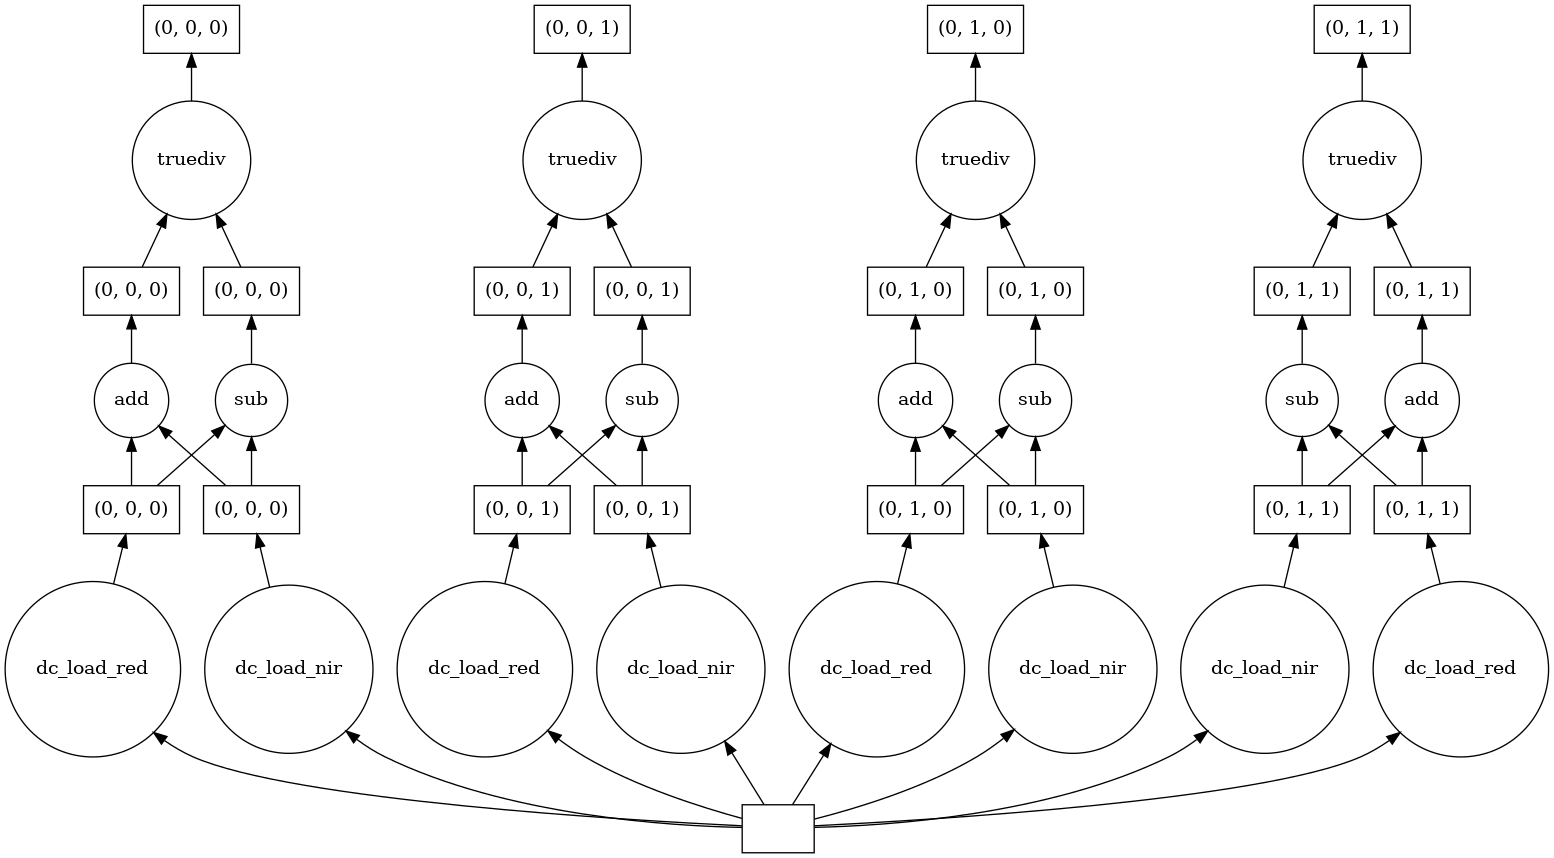

In [8]:
lazy_data.ndvi.data.visualize()

From viewing the task graph, we can now see the NDVI equation taking place using the red and nir bands. 

In [9]:
ndvi_compute = lazy_data.ndvi.compute()
ndvi_compute

<xarray.DataArray 'ndvi' (time: 1, y: 994, x: 965)>
array([[[0.21233616, 0.22875197, 0.20402869, ..., 0.42343153,
         0.43450479, 0.44335088],
        [0.18732949, 0.17376331, 0.1571875 , ..., 0.42226188,
         0.42863595, 0.42960126],
        [0.14910835, 0.13579444, 0.13274021, ..., 0.4057494 ,
         0.40607127, 0.40859978],
        ...,
        [0.08340284, 0.08749299, 0.0806496 , ..., 0.07265774,
         0.0716137 , 0.07172075],
        [0.07943476, 0.08121411, 0.07702721, ..., 0.07300463,
         0.07278139, 0.07266811],
        [0.0769853 , 0.07870933, 0.07785888, ..., 0.07255089,
         0.07342045, 0.07429341]]])
Coordinates:
  * time         (time) datetime64[ns] 2021-07-02T11:59:59.999999
  * y            (y) float64 3.713e+06 3.713e+06 ... 3.703e+06 3.703e+06
  * x            (x) float64 3.078e+06 3.078e+06 ... 3.088e+06 3.088e+06
    spatial_ref  int32 6933

## Plotting the NDVI

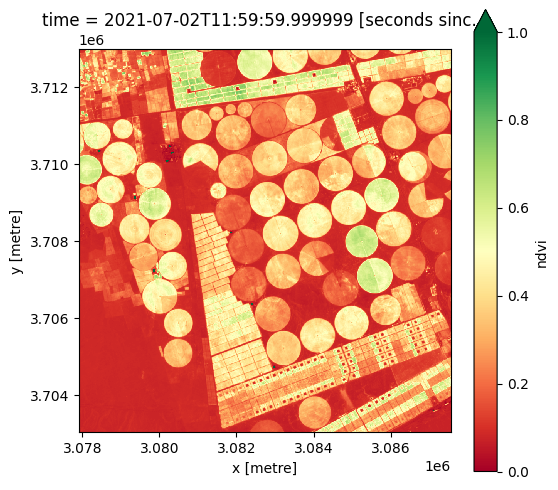

In [10]:
# formatting the figure 
fig , axis = plt.subplots(1, 1, figsize=(6, 6))
axis.set_aspect('equal')

ndvi_compute.plot(ax= axis, cmap='RdYlGn', vmin=0, vmax=1)

### Key Concepts
* Dask only loads data that is required/used by the final operation in the chain, task graphs are used to visualise where required data stems from 
* Task graphs are a visual representation of the series of steps taken to execute a loading operation
    * **Rectangles** at the bottom of the graph are database entries which represent the chunks that need to be read to load the data
    * **Circles** above the rectangles are individual operation that will do the reading, there is one for each chunk
    * **Indexes** are located at the very top of the chunks which make up the final array
* In this tutorial we used `.compute()` to calculate the NDVI and specifically keep the ndvi data variable as a Dask array in lazy_load  xarray.dataset
    * `ndvi_compute` = `lazy_data.compute()` will load data into memory for `ndvi_compute`, but `lazy_data` will remain lazy

#### Further information

##### Lazy operations 
In addition to breaking data into smaller chunks that fit into memory, Dask has another advantage in that it can track how you want to work with the data, and from that only perform the necessary operations later.

##### Task graphs
Task graphs visually represent the series of steps taken to execute a loading operation. Task graphs are read from bottom-to-top (see below) whereby:

* **Rectangles** at the bottom of the graph are database entries which represent the files that need to be read to load the data
* **Circles** above the rectangles are individual load commands that will do the reading, there is one for each chunk
    * **Arrows** represent which files need to be read for each operation 
* **Indexes** are located at the very top of the chunks which make up the final array

##### Adding tasks
Before we request data to be loaded using Dask, tasks can be chained together prior to loading. This is an advantageous method as only data that is required by the final operation is loaded. 

##### Interpreting the task graph
In the above example we returned task graphs at two different points of loading data.

* Requesting a small portion of the red band: resulting in the new task ‘getitem’ to be added, as that is where the small portion of the red band we requested resides

<img align="middle" src="../../_static/sandbox/dask-howto/get-item.png" alt="Dask task graph get item." width="500">

* Chaining operations together for calculating the NDVI: resulted in ‘add’ and ‘sub’ being performed on each band before being divided ‘truediv’

<img align="middle" src="../../_static/sandbox/dask-howto/add-sub-operations.png" alt="Dask task graph operations chain." width="700">

We can see how each output chunk is independent from one another. This allows for each chunk to be calculated without having to load all the bands into memory at the same time.